In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture 
from scipy.stats import wasserstein_distance
from sklearn.metrics import mutual_info_score
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)

In [4]:
def variation_of_information(labels_true, labels_pred):
   labels_true = np.asarray(labels_true, dtype=np.int32)
   labels_pred = np.asarray(labels_pred, dtype=np.int32)
   contingency = np.histogram2d(labels_true, labels_pred, bins=(np.max(labels_true) + 1, np.max(labels_pred) + 1))[0]
   H_true = -np.sum(contingency.sum(axis=1) / len(labels_true) * np.log(contingency.sum(axis=1) / len(labels_true)))
   H_pred = -np.sum(contingency.sum(axis=0) / len(labels_pred) * np.log(contingency.sum(axis=0) / len(labels_pred)))
   I = mutual_info_score(labels_true, labels_pred)
   return H_true + H_pred - 2 * I

In [5]:
def optimize_clustering(params, data, true_labels, algorithm, manual_n_clusters=None):
   random_state = 42
   if algorithm == 'HDBSCAN':
       clusterer = hdbscan.HDBSCAN(min_samples=int(params['min_samples']),
                                   min_cluster_size=int(params['min_cluster_size']),
                                   metric=params['metric'],
                                   cluster_selection_method=params['cluster_selection_method'])
   elif algorithm == 'KMeans':
       clusterer = KMeans(n_clusters=manual_n_clusters if manual_n_clusters else int(params['n_clusters']), random_state=42, n_init=10)
   elif algorithm == 'AgglomerativeClustering':
       linkage = params['linkage'] 
       affinity = 'euclidean' if linkage == 'ward' else params['affinity'] 
       clusterer = AgglomerativeClustering(n_clusters=manual_n_clusters if manual_n_clusters else int(params['n_clusters']), affinity=affinity, linkage=linkage)
  
   cluster_labels = clusterer.fit_predict(data)
   if len(np.unique(cluster_labels)) > 1:
       silhouette_avg = silhouette_score(data, cluster_labels)
       ari = adjusted_rand_score(true_labels, cluster_labels)
       score = 0.5 * silhouette_avg + 0.5 * ari  
   else:
       score = -1
   return {'loss': -score, 'status': STATUS_OK}

In [6]:
def bayesian_optimization(data, true_labels, algorithm, manual_n_clusters=None):
   if algorithm == 'HDBSCAN':
       space = {
           'min_samples': hp.quniform('min_samples', 5, 100, 1),
           'min_cluster_size': hp.quniform('min_cluster_size', 2, 100, 1),
           'metric': hp.choice('metric', ['euclidean', 'manhattan']),
           'cluster_selection_method': hp.choice('cluster_selection_method', ['eom', 'leaf'])
       }
   elif algorithm == 'KMeans':
       space = {
           'n_clusters': hp.quniform('n_clusters', 2, 20, 1)
       }
   elif algorithm == 'AgglomerativeClustering':
       space = {
           'n_clusters': hp.quniform('n_clusters', 2, 20, 1),
           'affinity': hp.choice('affinity', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']),
           'linkage': hp.choice('linkage', ['ward', 'complete', 'average', 'single'])
       }
   trials = Trials()
   
   rng = np.random.default_rng(42)
   best = fmin(fn=lambda params: optimize_clustering(params, data, true_labels, algorithm, manual_n_clusters),
               space=space,
               algo=tpe.suggest,
               max_evals=200,
               trials=trials,
               rstate=rng)
   if algorithm == 'HDBSCAN':
       best_params = {
           'min_samples': int(best['min_samples']),
           'min_cluster_size': int(best['min_cluster_size']),
           'metric': ['euclidean', 'manhattan'][best['metric']],
           'cluster_selection_method': ['eom', 'leaf'][best['cluster_selection_method']]
       }
   elif algorithm == 'KMeans':
       best_params = {
           'n_clusters': manual_n_clusters if manual_n_clusters else int(best['n_clusters'])
       }
   elif algorithm == 'AgglomerativeClustering':
      best_params = { 'n_clusters': manual_n_clusters if manual_n_clusters else int(best['n_clusters']), 
                      'affinity': 'euclidean' if best['linkage'] == 0 else ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'][best['affinity']], 
                      'linkage': ['ward', 'complete', 'average', 'single'][best['linkage']] 
       }
   return best_params


In [7]:
def clustering_pipeline(feat_df, y_param, colors, s, algorithm, manual_n_clusters=None, subset_values=None ):
   ideal_perplexity = math.sqrt(feat_df.shape[0])
   standardized_data = StandardScaler().fit_transform(feat_df)
 
   tsne = TSNE(n_components=2, perplexity=ideal_perplexity, n_jobs=-1, n_iter=1000,
               learning_rate='auto', init='random', random_state=42)
   tsne_results = tsne.fit_transform(standardized_data)
   tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE 1', 't-SNE 2'])
    
   if subset_values is not None:
       subset_indices = y_param.isin(subset_values)
       tsne_df = tsne_df[subset_indices].reset_index(drop=True)
       y_param = y_param[subset_indices].reset_index(drop=True)
           
   best_params = bayesian_optimization(tsne_df, y_param, algorithm, manual_n_clusters)
   print(f"Best {algorithm} parameters:", best_params)
    
   if algorithm == 'HDBSCAN':
       clusterer = hdbscan.HDBSCAN(min_samples=best_params['min_samples'],
                                   min_cluster_size=9,
                                   metric=best_params['metric'],
                                   cluster_selection_method=best_params['cluster_selection_method'])
   elif algorithm == 'KMeans':
       clusterer = KMeans(n_clusters=best_params['n_clusters'], random_state=42, n_init=10)
   elif algorithm == 'AgglomerativeClustering':
       clusterer = AgglomerativeClustering(n_clusters=best_params['n_clusters'], affinity=best_params['affinity'], linkage=best_params['linkage'])
   cluster_labels = clusterer.fit_predict(tsne_df)
   tsne_df['Cluster'] = cluster_labels
           
   le = LabelEncoder()
   encoded_y_param = le.fit_transform(y_param)
   vi = variation_of_information(encoded_y_param, cluster_labels)
   ari = adjusted_rand_score(encoded_y_param, cluster_labels)
   wd = wasserstein_distance(encoded_y_param, cluster_labels)
   sil = silhouette_score(tsne_df[['t-SNE 1', 't-SNE 2']] , cluster_labels)
   print(f"Variation of Information: {vi}")
   print(f"Adjusted Rand Index: {ari}")
   print(f"Wasserstein Distance: {wd}")
   print(f"Silhoutte Score: {sil}")


   contingency_table = pd.crosstab(pd.Series(y_param, name='Ground Truth'), pd.Series(cluster_labels, name='Cluster'))
   contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
   contingency_table_inverse_percentage = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
   print("\nContingency Table (Ground Truth vs Cluster):")
   print(contingency_table)
   print("\nPercentage of each Ground Truth in each Cluster:")
   print(contingency_table_percentage)
   print("\nPercentage of each Cluster in each Ground Truth:")
   print(contingency_table_inverse_percentage)
   
   fig = plt.figure(figsize=(12, 12))
   ax = fig.add_subplot(1, 1, 1)
   ax.set_title(f'Megase t-SNE and {algorithm} clustering', fontsize=20)
   ax.grid(False)
   unique_clusters = np.unique(cluster_labels)
   for cluster in unique_clusters:
       indicesToKeep = tsne_df['Cluster'] == cluster
       ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'],
                  tsne_df.loc[indicesToKeep, 't-SNE 2'],
                  c=colors[cluster % len(colors)],
                  s=s, label=f'Cluster {cluster}')
   ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   plt.savefig(f't-SNE and {algorithm} clustering.png')
   plt.show()

In [8]:
def manual_clustering(feat_df, y_param, colors, s, algorithm, params, subset_values=None):
   ideal_perplexity = math.sqrt(feat_df.shape[0])
   standardized_data = StandardScaler().fit_transform(feat_df)
   tsne = TSNE(n_components=2, perplexity=ideal_perplexity, n_jobs=-1, n_iter=1000,
               learning_rate='auto', init='random', random_state=42)
   tsne_results = tsne.fit_transform(standardized_data)
   tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE 1', 't-SNE 2'])
   if subset_values is not None:
       subset_indices = y_param.isin(subset_values)
       tsne_df = tsne_df[subset_indices].reset_index(drop=True)
       y_param = y_param[subset_indices].reset_index(drop=True)
   if algorithm == 'HDBSCAN':
       clusterer = hdbscan.HDBSCAN(min_samples=params['min_samples'],
                                   min_cluster_size=params['min_cluster_size'],
                                   metric=params['metric'],
                                   cluster_selection_method=params['cluster_selection_method'])
   elif algorithm == 'KMeans':
       clusterer = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
   elif algorithm == 'AgglomerativeClustering':
       clusterer = AgglomerativeClustering(n_clusters=params['n_clusters'], affinity=params['affinity'], linkage=params['linkage'])
   cluster_labels = clusterer.fit_predict(tsne_df)
   tsne_df['Cluster'] = cluster_labels
   le = LabelEncoder()
   encoded_y_param = le.fit_transform(y_param)
   if len(np.unique(cluster_labels)) > 1:
       silhouette_avg = silhouette_score(tsne_df[['t-SNE 1', 't-SNE 2']], cluster_labels)
   else:
       silhouette_avg = -1
   vi = variation_of_information(encoded_y_param, cluster_labels)
   ari = adjusted_rand_score(encoded_y_param, cluster_labels)
   wd = wasserstein_distance(encoded_y_param, cluster_labels)
   print(f"Silhouette Score: {silhouette_avg}")
   print(f"Variation of Information: {vi}")
   print(f"Adjusted Rand Index: {ari}")
   print(f"Wasserstein Distance: {wd}")
   contingency_table = pd.crosstab(pd.Series(y_param, name='Ground Truth'), pd.Series(cluster_labels, name='Cluster'))
   contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
   contingency_table_inverse_percentage = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
   print("\nContingency Table (Ground Truth vs Cluster):")
   print(contingency_table)
   print("\nPercentage of each Ground Truth in each Cluster:")
   print(contingency_table_percentage)
   print("\nPercentage of each Cluster in each Ground Truth:")
   print(contingency_table_inverse_percentage)
   fig = plt.figure(figsize=(12, 12))
   ax = fig.add_subplot(1, 1, 1)
   ax.set_title(f'Megaset t-SNE and {algorithm} clustering', fontsize=20)
   ax.grid(False)
   unique_clusters = np.unique(cluster_labels)
   for cluster in unique_clusters:
       indicesToKeep = tsne_df['Cluster'] == cluster
       ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'],
                  tsne_df.loc[indicesToKeep, 't-SNE 2'],
                  c=colors[cluster % len(colors)],
                  s=s, label=f'Cluster {cluster}')
   ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   plt.savefig(f't-SNE and {algorithm} clustering.png')
   plt.show()

In [27]:
#Params used for Manual Clustering
params = {
   'min_samples': 10,
   'min_cluster_size': 2,
   'metric': 'euclidean',
   'cluster_selection_method': 'eom',
   'n_clusters': 2,
   'affinity': 'l2',
   'linkage': 'average'
}

In [25]:
colors = [
    '#00c853', # Green
    '#d50000', # Red
]
all_colors = [
    '#d50000', # Red
    '#00c853', # Green
    '#3e2723', # Brown
    '#6200ea', # Deep Purple
    '#ff6d00', # Orange
    '#2962ff', # Blue
    '#c51162', # Pink
    '#0091ea', # Light Blue
    '#aeea00', # Lime
    '#2196f3', # Blue 2
    '#304ffe', # Indigo
    '#aa00ff', # Purple
    '#263238', # Blue Grey
    '#00b8d4', # Cyan
    '#ffab00', # Amber
    '#9e9e9e', # Grey 2
    '#ffc107', # Golden
    '#00bcd4', # Cyan 2
    '#00bfa5', # Teal
    '#ff6d00', # Orange
    '#dd2c00', # Deep Orange
    '#212121', # Grey
    '#9c27b0', # Purple 2
    '#ff5722', # Orange 2
    '#4caf50', # Green 2
    '#c51162', # Pink
    '#00bfa5', # Teal
    '#64dd17', # Light Green
    '#f44336', # Red 2
    '#795548', # Brown 2
    '#607d8b', # Blue Grey 2
    '#e91e63', # Pink 2

]

nine_colors = [
    '#d50000', # Red
    '#00c853', # Green
    '#ff6d00', # Orange
    '#2962ff', # Blue
    '#3e2723', # Brown
    '#00bfa5', # Teal
    '#6200ea', # Deep Purple
    '#c51162', # Pink
    '#aeea00', # Lime

]


## Importing Dataset

In [11]:
feature_df = pd.read_csv(r"C:\Users\m.soliman\Downloads\Radiomics\20240401_Megaset_features_v0_original.csv")

## Pre-Processing

In [12]:
def classify_segment(segment):
   if segment.startswith('0'):
       return 'Primary'
   elif segment.startswith('1.3'):
       return 'Lymph Nodes'
   elif segment.startswith('1.1.05'):
       return 'Lung mets'
   elif segment.startswith('1.1.11'):
       return 'Liver mets'
   elif segment.startswith('1.4.03') or segment.startswith('1.4.04') or segment.startswith('1.1.16'):
       return 'Abdopelvis mets'
   elif segment.startswith('1.2'):
       return 'Bone mets'
   elif segment.startswith('1.1.01'):
       return 'Brain mets'
   elif segment.startswith('1.1.17'):
       return 'Adrenal mets'
   else:
       return 'Others'

In [13]:
lymph_mapping = {
   '3.01': 'Head and Neck',
   '3.02': 'Thoracic',
   '3.03': 'Thoracic',
   '3.04': 'Thoracic',
   '3.05': 'Thoracic',
   '3.06': 'Thoracic',
   '3.07': 'Thoracic',
   '3.08': 'Thoracic',
   '3.09': 'Thoracic',
   '3.10': 'Thoracic',
   '3.11': 'Thoracic',
   '3.12': 'Thoracic',
   '3.13': 'Thoracic',
   '3.14': 'Thoracic',
   '3.15': 'Abdominal',
   '3.16': 'Abdominal',
   '3.19': 'Abdominal',
   '3.17': 'Pelvic',
   '3.18': 'Pelvic',
   '3.20': 'Abdominal', 
   '3.21': 'Thoracic',
   '3.22': 'Abdominal'
}


In [14]:
feature_df['lesion_type'] = feature_df['Segment Name'].apply(lambda x: '.'.join(x.split('.')[:3]))
categories = ['CRC', 'Melanoma', 'Lung', 'Pancreas', 'Kidney', 'Liver']
feature_df['categories']= feature_df['tumtype'].apply(lambda x: x if x in categories else 'none')
one_hot_encoded_df = pd.get_dummies(feature_df['categories'], prefix='tumtype').astype(int)
names = {
    'tumtype_CRC':'binary CRC',
    'tumtype_Pancreas':'binary Pancreas',
    'tumtype_Melanoma':'binary Melanoma',
    'tumtype_Kidney':'binary Kidney',
    'tumtype_Lung':'binary lung',
    'tumtype_Liver': 'binary liver'}
one_hot_encoded_df.rename(columns=names, inplace=True)
one_hot_encoded_df = one_hot_encoded_df.drop('tumtype_none', axis=1)
feature_df = pd.concat([feature_df, one_hot_encoded_df], axis=1)
feature_df = feature_df.rename(columns={'tumtype': 'tumour_type3_y'})
feature_df = feature_df.drop('categories', axis=1)
feature_df['binary primary metastasis'] = feature_df['Segment Name'].apply(lambda x: 0 if x.startswith('0') else 1)
feature_df['binary primary tumor'] = feature_df['Segment Name'].str.startswith('0').astype(int)
feature_df['lesion_type_metastatis'] = feature_df['Segment Name'].apply(lambda x: '0' if x.startswith('0') else '.'.join(x.split('.')[1:3]))
feature_df['lesion_place'] = feature_df['Segment Name'].apply(lambda x:'.'.join(x.split('.')[1:3]))
feature_df['binary primary lung'] = np.where((feature_df['binary lung'] == 1) & (feature_df['binary primary tumor'] == 0), 1, np.where((feature_df['binary lung'] == 1) & (feature_df['binary primary tumor'] == 1), 0, 2))
feature_df['binary primary liver'] = np.where((feature_df['binary liver'] == 1) & (feature_df['binary primary tumor'] == 0), 1, np.where((feature_df['binary liver'] == 1) & (feature_df['binary primary tumor'] == 1), 0, 2))
feature_df['binary primary CRC'] = np.where((feature_df['binary CRC'] == 1) & (feature_df['binary primary tumor'] == 0), 1, np.where((feature_df['binary CRC'] == 1) & (feature_df['binary primary tumor'] == 1), 0, 2))
feature_df['lesion space'] = feature_df['Segment Name'].str.split('.').str[1]
feature_df['Location'] = feature_df['Segment Name'].apply(classify_segment)
feature_df['Lymph_type'] = np.where(feature_df['Location'] == 'Lymph Nodes', feature_df['lesion_place'].map(lymph_mapping), np.nan)
feature_df

,Unnamed: 0,Project,Case,tumour_type3_y,Segment ID,Segment Name,Segment index,Label,Label_channel,Dimensionality,...,binary primary metastasis,binary primary tumor,lesion_type_metastatis,lesion_place,binary primary lung,binary primary liver,binary primary CRC,lesion space,Location,Lymph_type
0,0,(HCC-TACE-Seg),HCC_001,Liver,Segment_1,0.1.11.1,0,1,0,3D,...,0,1,0,1.11,2,0,2,1,Primary,NaN
1,1,(HCC-TACE-Seg),HCC_002,Liver,Segment_1,0.1.11.1,0,1,0,3D,...,0,1,0,1.11,2,0,2,1,Primary,NaN
2,2,(HCC-TACE-Seg),HCC_002,Liver,Segment_2,0.1.11.2,1,2,0,3D,...,0,1,0,1.11,2,0,2,1,Primary,NaN
3,3,(HCC-TACE-Seg),HCC_002,Liver,Segment_3,1.3.15.1,2,3,0,3D,...,1,0,3.15,3.15,2,1,2,3,Lymph Nodes,Abdominal
4,4,(HCC-TACE-Seg),HCC_003,Liver,Segment_1,0.1.11.1,0,1,0,3D,...,0,1,0,1.11,2,0,2,1,Primary,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6623,6693,(HCC-TACE-Seg),HCC_065,Liver,Segment_5,0.1.11.1,3,5,0,3D,...,0,1,0,1.11,2,0,2,1,Primary,NaN
6624,6694,CPTAC-SAR,C3N-04164,Sarcoma,Segment_1,0.2.07,0,1,0,3D,...,0,1,0,2.07,2,2,2,2,Primary,NaN
6625,6695,CPTAC-UCEC,C3N-00520,Uterus,Segment_1,0.1.22,0,1,0,3D,...,0,1,0,1.22,2,2,2,1,Primary,NaN
6626,6696,WORC-GIST,GIST-220,Sarcoma,Segment_1,0.1.09,0,1,0,3D,...,0,1,0,1.09,2,2,2,1,Primary,NaN


## Defining tumor df and y param

In [15]:
x_start = feature_df.columns.get_loc('original_shape_Elongation')
x_end = feature_df.columns.get_loc('lbp-3D-k_ngtdm_Strength')+1

In [16]:
# definition of all tumors df 
all_df = feature_df.dropna(subset='tumour_type3_y')
all_df = all_df.iloc[:, x_start:x_end].fillna(all_df.median(numeric_only=True))


In [17]:
primary_df = feature_df[feature_df['binary primary tumor'] == 1]
primary_df = primary_df.dropna(subset='tumour_type3_y')
primary_feat_df = primary_df.iloc[:, x_start:x_end].fillna(feature_df.median(numeric_only=True))
primary_outcome_name = 'Tumour_Type'

primary_y_param = primary_df['tumour_type3_y']
primary_lung_y_param = primary_df['binary lung']

In [18]:
## Step 1: all tumor types with patient level(diagnosis) label and anatomical location

patient_level_y_param = feature_df['tumour_type3_y']
Location_y_param = feature_df['Location']
lymph_y_param = feature_df['Lymph_type']

## Clustering of all lesions

### Using hyperparameters PANCANCER (n_clusters=5, affinity= euclidean, linkage = ward)

Silhouette Score: 0.40045174956321716
Variation of Information: 2.099034713053763
Adjusted Rand Index: 0.21822253024611965
Wasserstein Distance: 2.827417380660955

Contingency Table (Ground Truth vs Cluster):
Cluster            0    1    2    3     4
Ground Truth                             
Abdopelvis mets    1    9   85    7    43
Adrenal mets       0    7    7    8     6
Bone mets         12   18    3    2     0
Liver mets         1   14   98  626   278
Lung mets        970  117    0    0     0
Lymph Nodes      102  328  820  156    65
Primary          475  629  197  425  1027

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4
Ground Truth                                                          
Abdopelvis mets   0.689655   6.206897  58.620690   4.827586  29.655172
Adrenal mets      0.000000  25.000000  25.000000  28.571429  21.428571
Bone mets        34.285714  51.428571   8.571429   5.714286   0.000000
Liver me

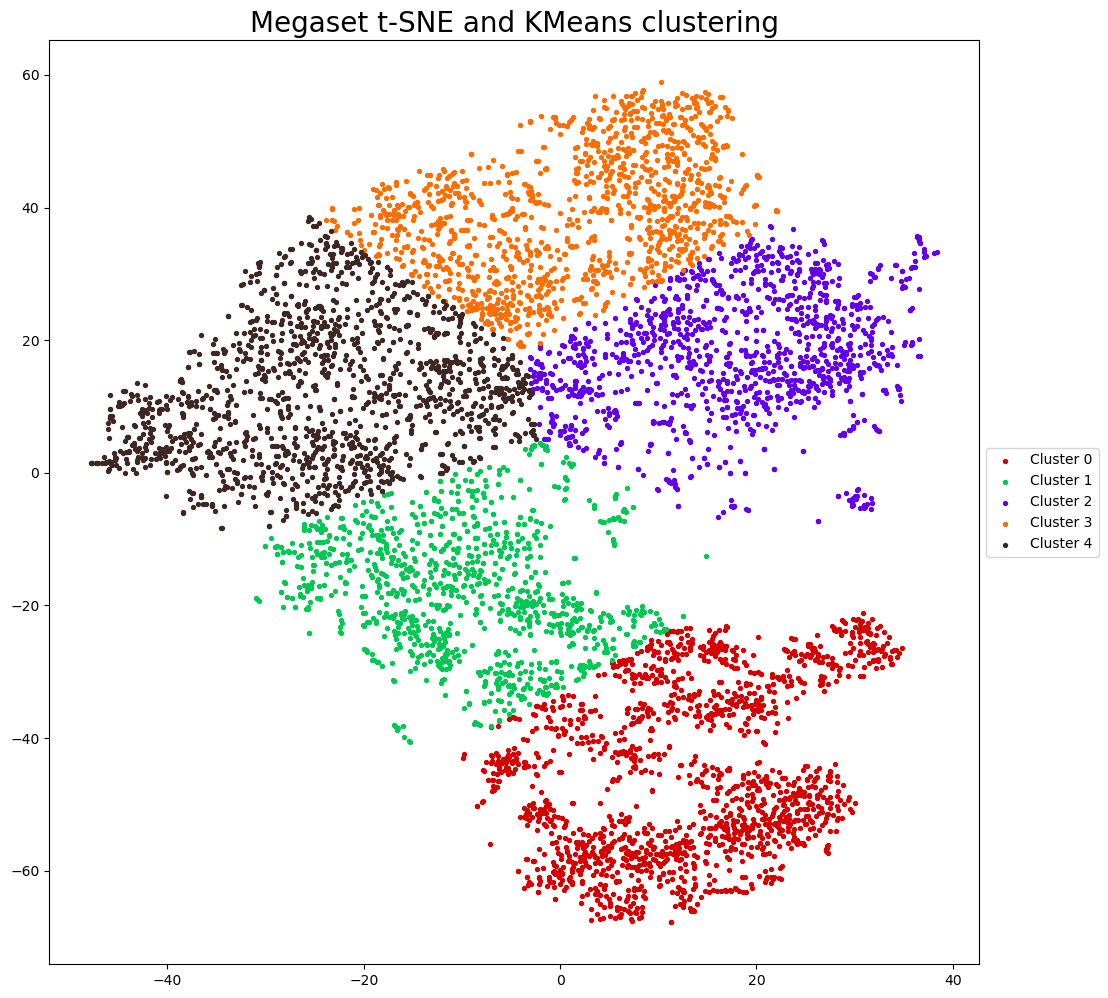

In [23]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans',params=params, subset_values=['Primary', 'Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                           

Silhouette Score: 0.39941343665122986
Variation of Information: 2.071900867306323
Adjusted Rand Index: 0.21667746002582752
Wasserstein Distance: 3.23546511627907

Contingency Table (Ground Truth vs Cluster):
Cluster             0    1     2    3    4
Ground Truth                              
Abdopelvis mets     1    5    48   86    5
Adrenal mets        0    7    12    8    1
Bone mets          12    0    17    4    2
Liver mets          1  446   115  119  336
Lung mets        1071    0    16    0    0
Lymph Nodes       169  159   286  823   34
Primary           675  671  1084  145  178

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4
Ground Truth                                                          
Abdopelvis mets   0.689655   3.448276  33.103448  59.310345   3.448276
Adrenal mets      0.000000  25.000000  42.857143  28.571429   3.571429
Bone mets        34.285714   0.000000  48.571429  11.428571   5.714286


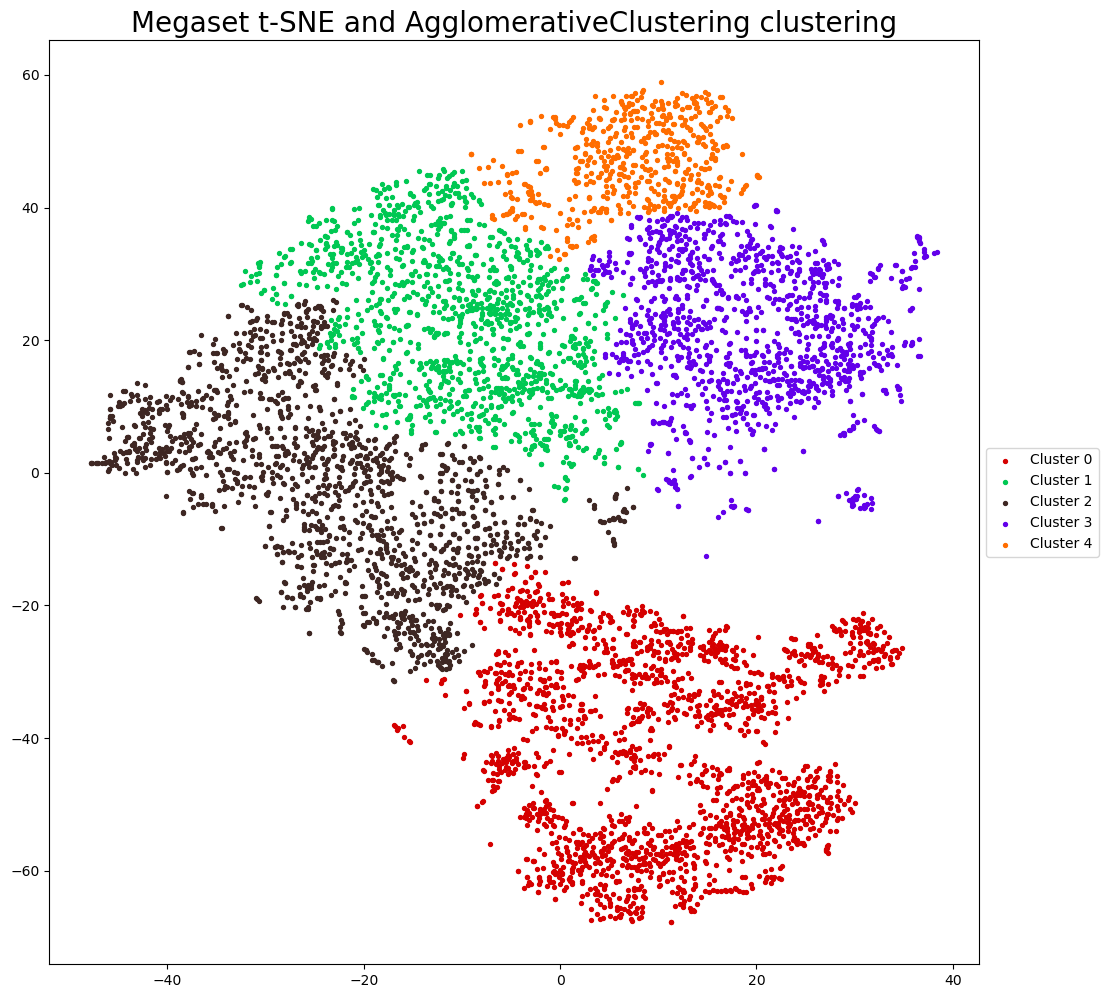

In [26]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', params=params, subset_values=['Primary', 'Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except primary

### Using hyperparameters PANCANCER (n_clusters=5, affinity= euclidean, linkage = ward)

Silhouette Score: 0.4506854712963104
Variation of Information: 1.5686638562481958
Adjusted Rand Index: 0.4369669203781523
Wasserstein Distance: 1.7065820777160983

Contingency Table (Ground Truth vs Cluster):
Cluster            0    1     2    3    4
Ground Truth                             
Abdopelvis mets   18    7     1   36   83
Adrenal mets       9    5     0    7    7
Bone mets          0    2    12   18    3
Liver mets       444  427     1   49   96
Lung mets          0    0  1002   85    0
Lymph Nodes       85  130   105  362  789

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4
Ground Truth                                                          
Abdopelvis mets  12.413793   4.827586   0.689655  24.827586  57.241379
Adrenal mets     32.142857  17.857143   0.000000  25.000000  25.000000
Bone mets         0.000000   5.714286  34.285714  51.428571   8.571429
Liver mets       43.657817  41.986234   0.098328  

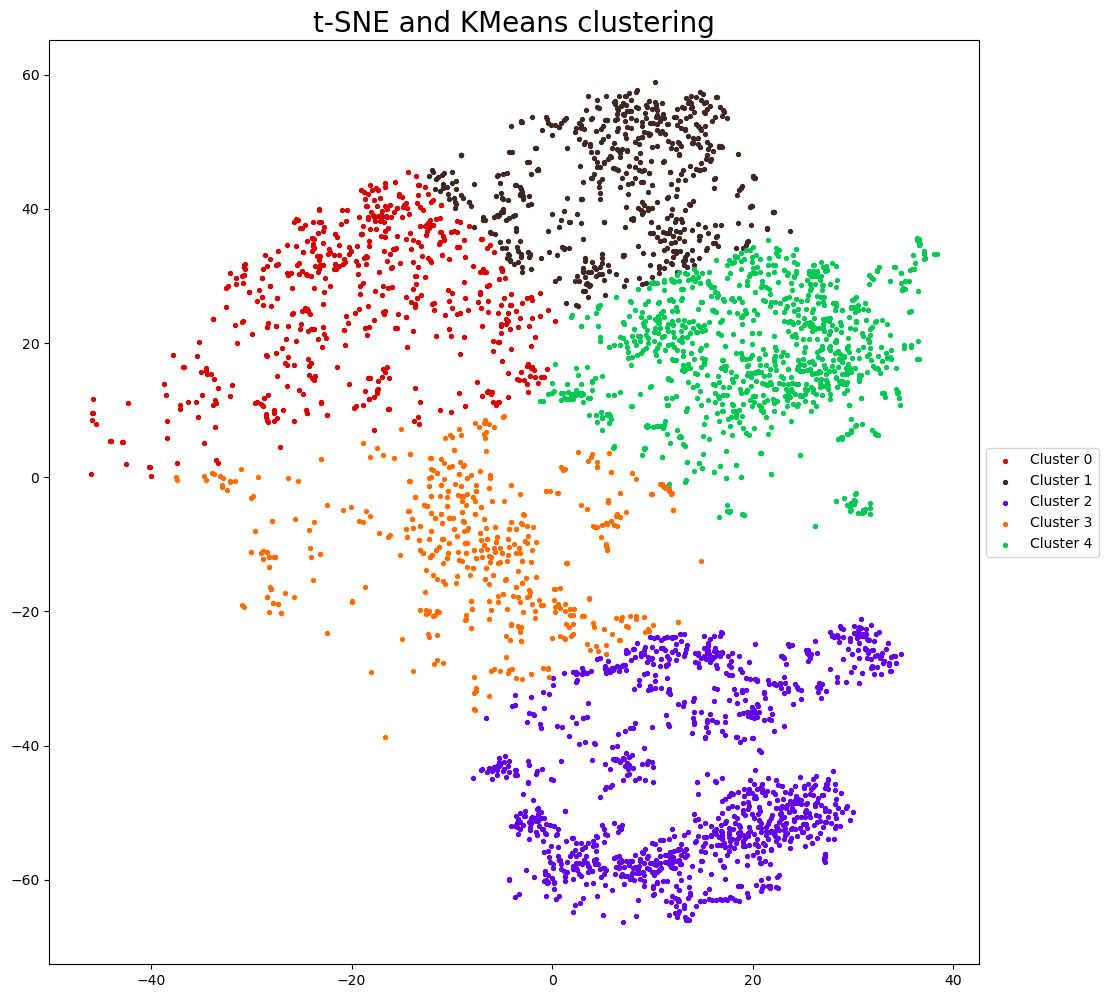

In [33]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', params=params, subset_values=['Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

Silhouette Score: 0.35601606965065
Variation of Information: 1.7190978260353282
Adjusted Rand Index: 0.29854510342091767
Wasserstein Distance: 1.9545334390695217

Contingency Table (Ground Truth vs Cluster):
Cluster            0    1    2    3    4
Ground Truth                            
Abdopelvis mets   49   14    0   81    1
Adrenal mets       5   13    0   10    0
Bone mets          4    4   14    2   11
Liver mets       206  731    1   79    0
Lung mets          3    0  468    0  616
Lymph Nodes      278  454   70  568  101

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1          2          3          4
Ground Truth                                                          
Abdopelvis mets  33.793103   9.655172   0.000000  55.862069   0.689655
Adrenal mets     17.857143  46.428571   0.000000  35.714286   0.000000
Bone mets        11.428571  11.428571  40.000000   5.714286  31.428571
Liver mets       20.255654  71.878073   0.098328   7.767945

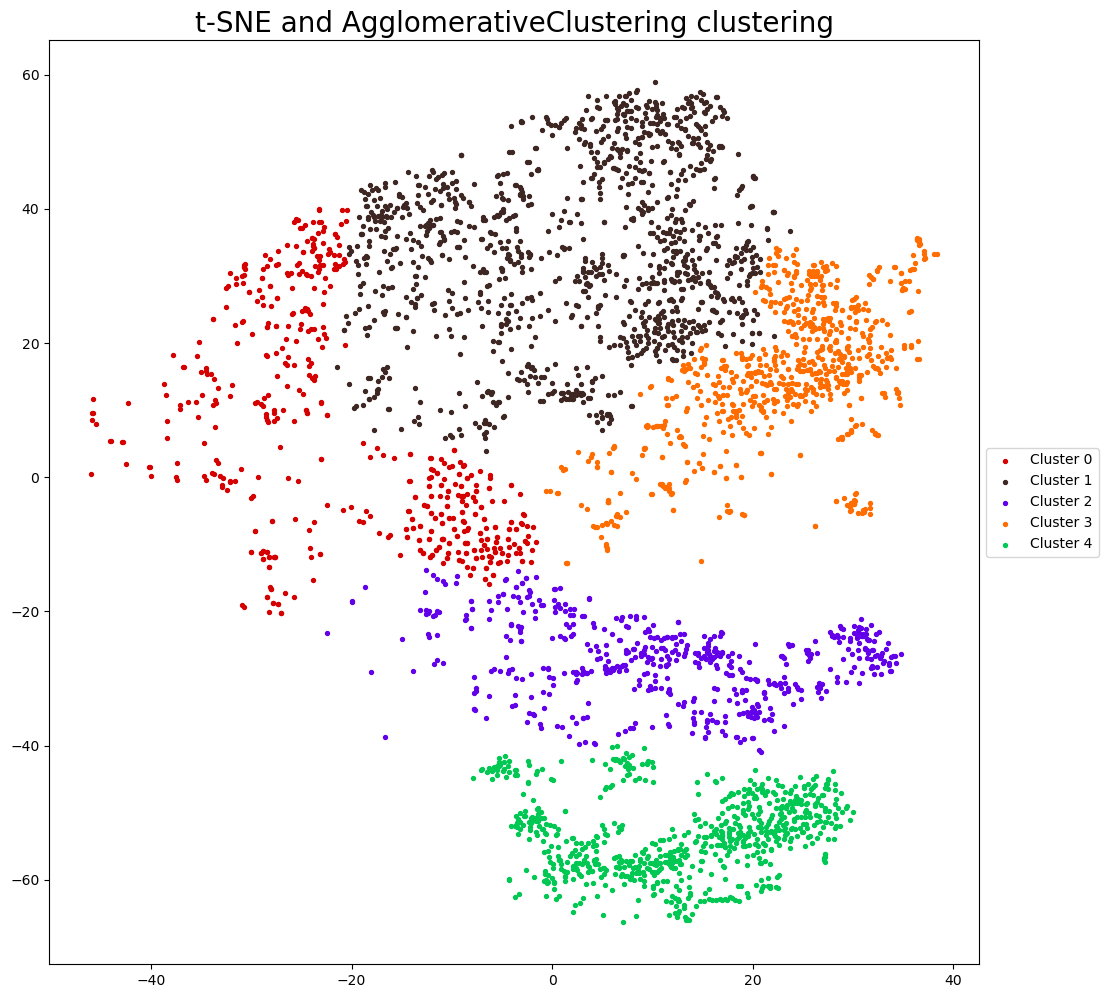

In [34]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering',  params=params, subset_values=['Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except Lymph nodes

### Using hyperparameters PANCANCER (n_clusters=2, affinity= l1, linkage = average)

Silhouette Score: 0.5426068305969238
Variation of Information: 1.1986818678924724
Adjusted Rand Index: 0.20229274920746515
Wasserstein Distance: 3.7889437314906216

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1
Ground Truth               
Abdopelvis mets   140     5
Adrenal mets       28     0
Bone mets           9    26
Liver mets       1015     2
Lung mets           1  1086
Primary          1801   952

Percentage of each Ground Truth in each Cluster:
Cluster                   0          1
Ground Truth                          
Abdopelvis mets   96.551724   3.448276
Adrenal mets     100.000000   0.000000
Bone mets         25.714286  74.285714
Liver mets        99.803343   0.196657
Lung mets          0.091996  99.908004
Primary           65.419542  34.580458

Percentage of each Cluster in each Ground Truth:
Cluster                  0          1
Ground Truth                         
Abdopelvis mets   4.676019   0.241429
Adrenal mets      0.935204   0.000000
Bo

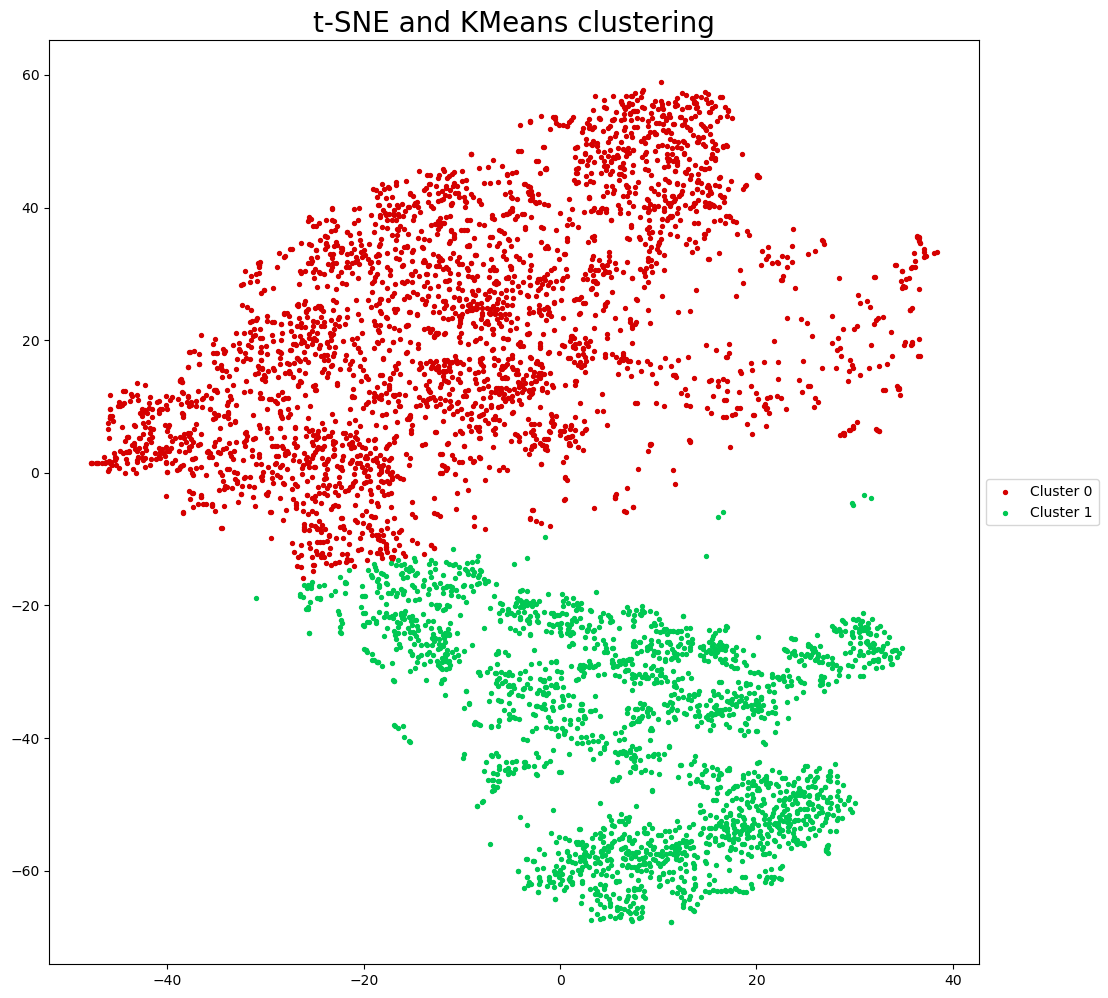

In [26]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', params=params, subset_values=['Primary', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

Silhouette Score: 0.5258862376213074
Variation of Information: 1.1531740909644128
Adjusted Rand Index: 0.24735106520159397
Wasserstein Distance: 3.851924975320829

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1
Ground Truth               
Abdopelvis mets   144     1
Adrenal mets       28     0
Bone mets          23    12
Liver mets       1016     1
Lung mets          16  1071
Primary          2086   667

Percentage of each Ground Truth in each Cluster:
Cluster                   0          1
Ground Truth                          
Abdopelvis mets   99.310345   0.689655
Adrenal mets     100.000000   0.000000
Bone mets         65.714286  34.285714
Liver mets        99.901672   0.098328
Lung mets          1.471941  98.528059
Primary           75.771885  24.228115

Percentage of each Cluster in each Ground Truth:
Cluster                  0          1
Ground Truth                         
Abdopelvis mets   4.346514   0.057078
Adrenal mets      0.845155   0.000000
Bon

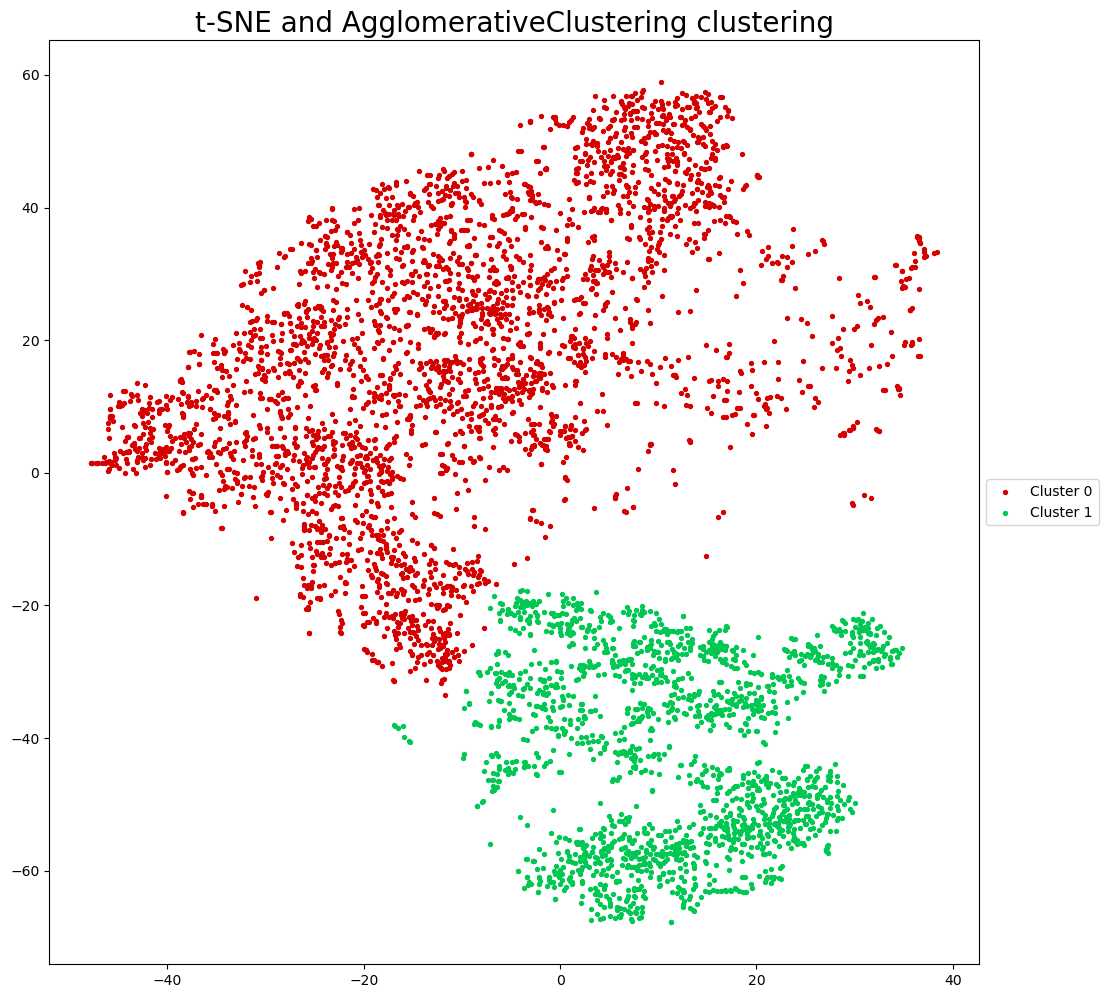

In [27]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', params=params, subset_values=['Primary', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## All lesions except primary and Lymph nodes

### Using hyperparameters PANCANCER (n_clusters=2, affinity= euclidean, linkage = ward)

Silhouette Score: 0.6401205658912659
Variation of Information: 0.37073398307560357
Adjusted Rand Index: 0.8309001661231836
Wasserstein Distance: 2.7292387543252596

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1
Ground Truth               
Abdopelvis mets     5   140
Adrenal mets        2    26
Bone mets          30     5
Liver mets          2  1015
Lung mets        1086     1

Percentage of each Ground Truth in each Cluster:
Cluster                  0          1
Ground Truth                         
Abdopelvis mets   3.448276  96.551724
Adrenal mets      7.142857  92.857143
Bone mets        85.714286  14.285714
Liver mets        0.196657  99.803343
Lung mets        99.908004   0.091996

Percentage of each Cluster in each Ground Truth:
Cluster                  0          1
Ground Truth                         
Abdopelvis mets   0.444444  11.794440
Adrenal mets      0.177778   2.190396
Bone mets         2.666667   0.421230
Liver mets        0.177778  85.509688


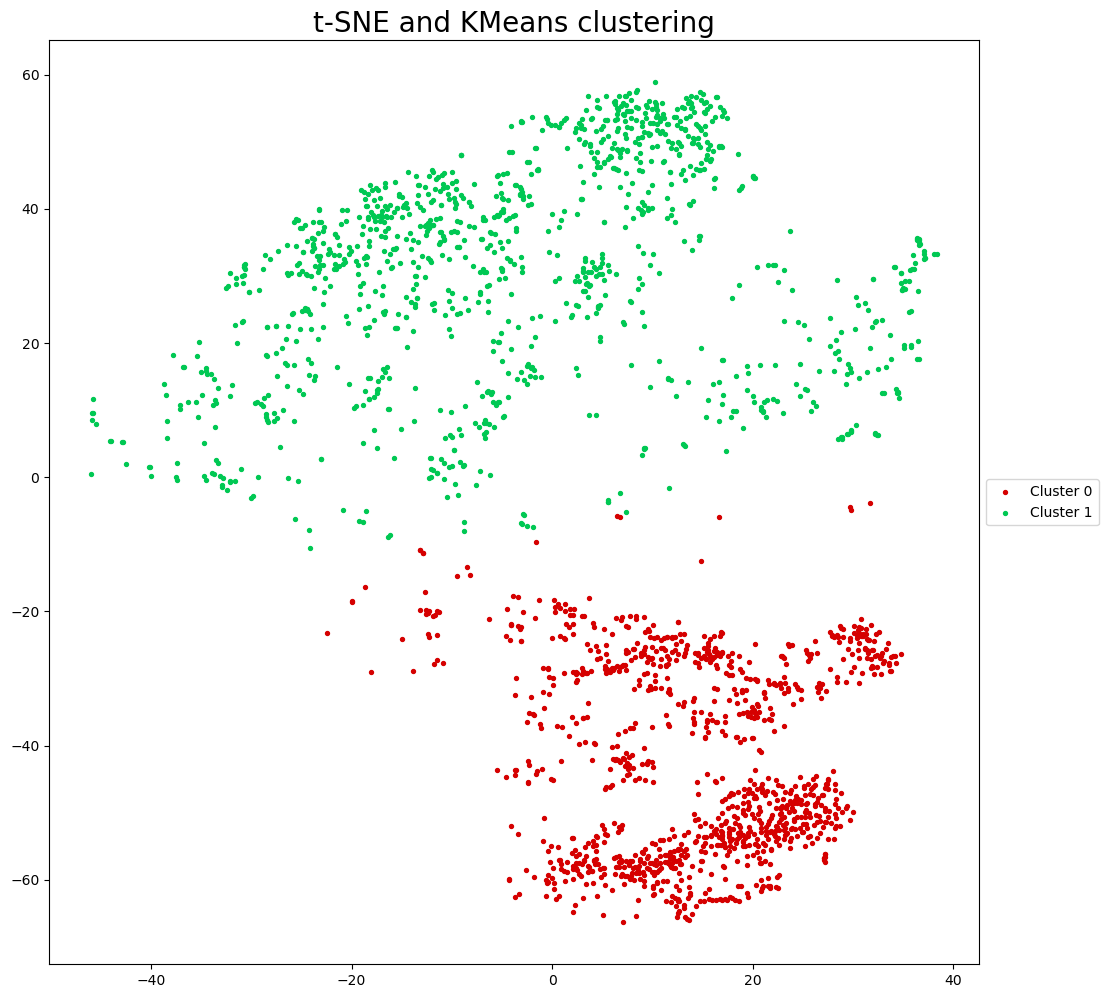

In [31]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='KMeans', params=params, subset_values=['Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

Silhouette Score: 0.6385505199432373
Variation of Information: 0.3957887524735817
Adjusted Rand Index: 0.8194433838126653
Wasserstein Distance: 2.754757785467128

Contingency Table (Ground Truth vs Cluster):
Cluster             0     1
Ground Truth               
Abdopelvis mets   142     3
Adrenal mets       28     0
Bone mets           6    29
Liver mets       1007    10
Lung mets           1  1086

Percentage of each Ground Truth in each Cluster:
Cluster                   0          1
Ground Truth                          
Abdopelvis mets   97.931034   2.068966
Adrenal mets     100.000000   0.000000
Bone mets         17.142857  82.857143
Liver mets        99.016716   0.983284
Lung mets          0.091996  99.908004

Percentage of each Cluster in each Ground Truth:
Cluster                  0          1
Ground Truth                         
Abdopelvis mets  11.993243   0.265957
Adrenal mets      2.364865   0.000000
Bone mets         0.506757   2.570922
Liver mets       85.050676   0.88

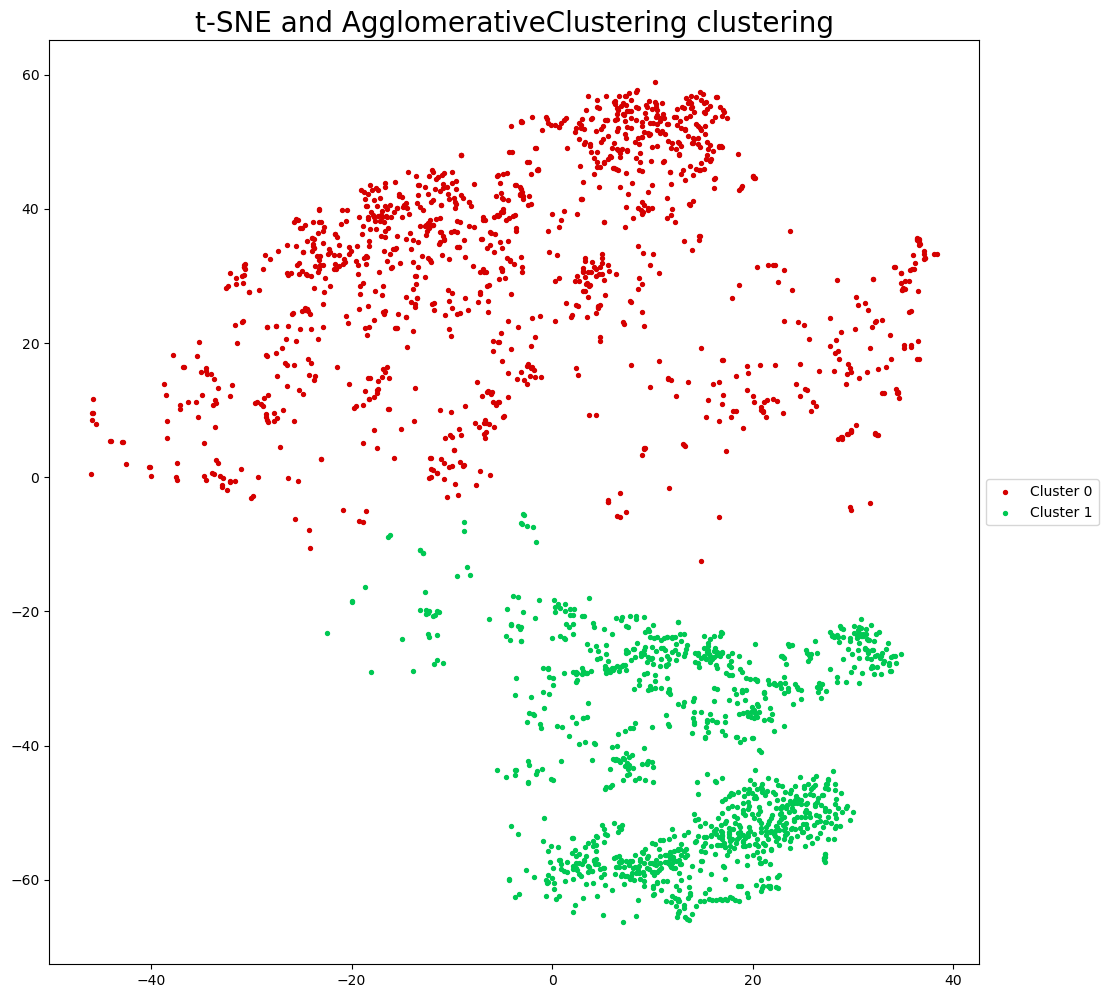

In [32]:
manual_clustering(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', params=params, subset_values=['Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])                    

## Only Primary tumors

### Using hyperparameters PANCANCER (n_clusters=2, affinity= l2, linkage = average)

Silhouette Score: 0.4921931326389313
Variation of Information: 0.353462847240983
Adjusted Rand Index: 0.8152309711483479
Wasserstein Distance: 0.25935343261896115

Contingency Table (Ground Truth vs Cluster):
Cluster         0    1
Ground Truth          
0             477  379
1             178  417

Percentage of each Ground Truth in each Cluster:
Cluster               0          1
Ground Truth                      
0             55.724299  44.275701
1             29.915966  70.084034

Percentage of each Cluster in each Ground Truth:
Cluster               0          1
Ground Truth                      
0             72.824427  47.613065
1             27.175573  52.386935


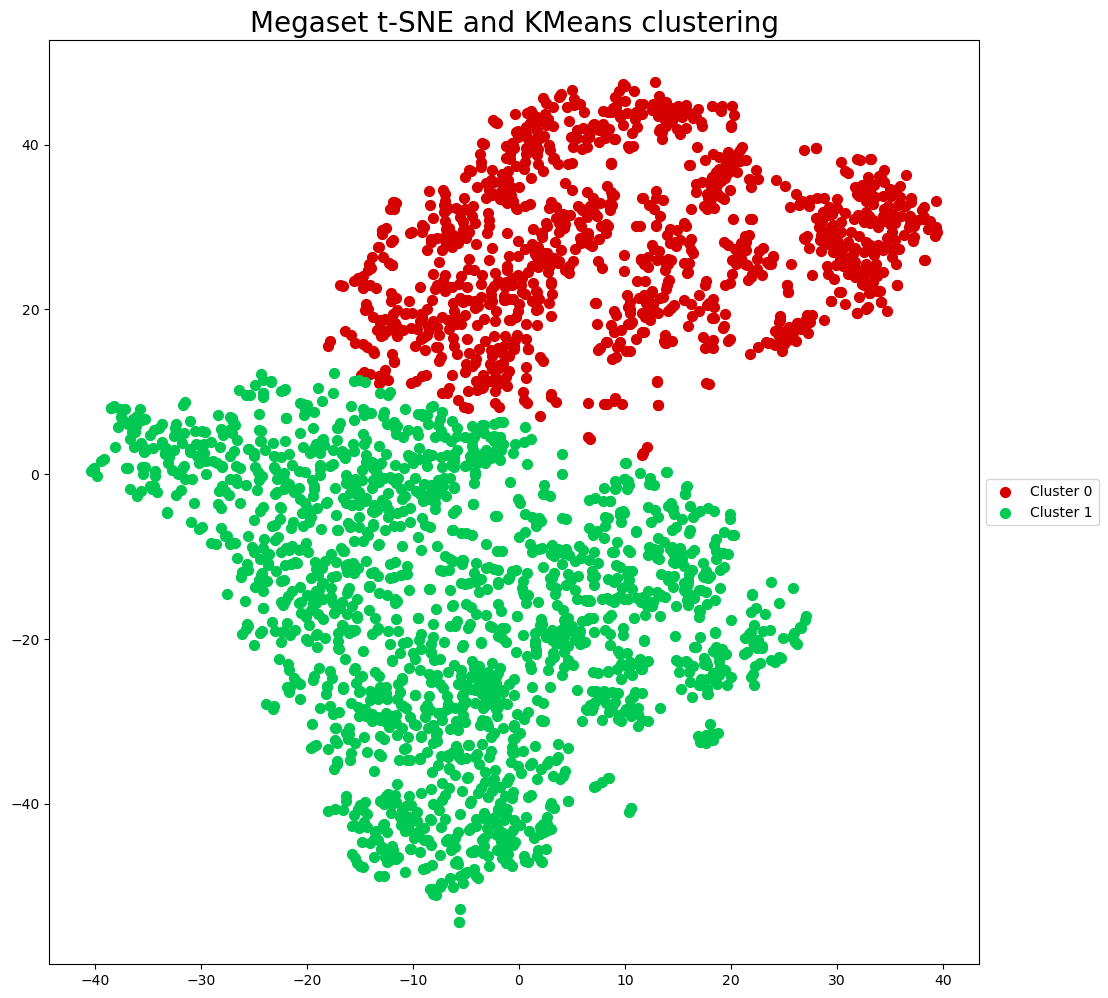

In [28]:
manual_clustering(feat_df=primary_feat_df, y_param=primary_lung_y_param, colors=all_colors, s=50, algorithm='KMeans', params=params, subset_values=None)                           

Silhouette Score: 0.4840877652168274
Variation of Information: 0.24213902971095513
Adjusted Rand Index: 0.8959427997245587
Wasserstein Distance: 0.002542680711950629

Contingency Table (Ground Truth vs Cluster):
Cluster         0    1
Ground Truth          
0             406  450
1             446  149

Percentage of each Ground Truth in each Cluster:
Cluster               0          1
Ground Truth                      
0             47.429907  52.570093
1             74.957983  25.042017

Percentage of each Cluster in each Ground Truth:
Cluster               0          1
Ground Truth                      
0             47.652582  75.125209
1             52.347418  24.874791


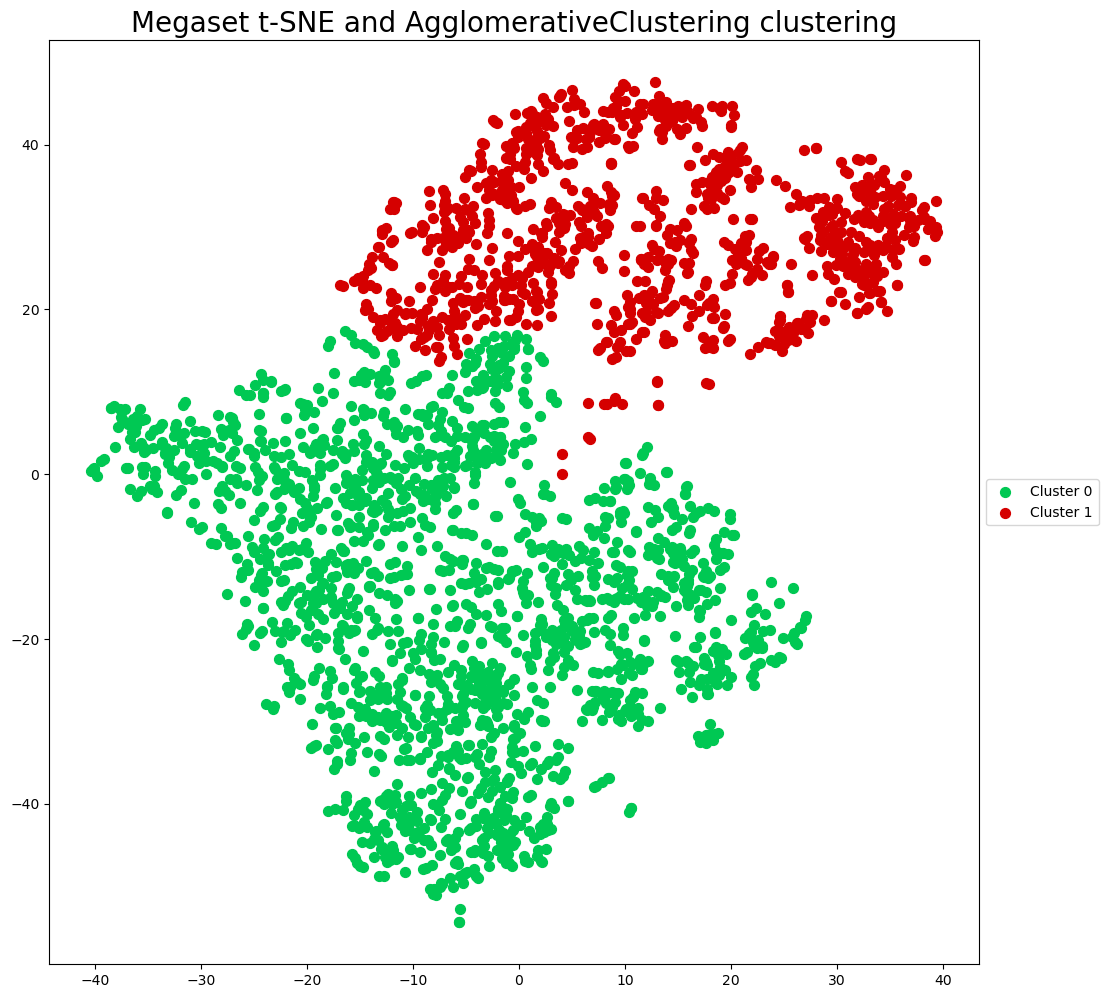

In [30]:
manual_clustering(feat_df=primary_feat_df, y_param=primary_lung_y_param, colors=colors, s=50, algorithm='AgglomerativeClustering', params=params, subset_values=None)                           

## Only Lymph Nodes Location

### Based on Bayesian optimization

100%|██████████| 200/200 [02:57<00:00,  1.13trial/s, best loss: -0.51372689366723] 
Best KMeans parameters: {'n_clusters': 2}
Variation of Information: 0.8336053668613217
Adjusted Rand Index: 0.47063381195833087
Wasserstein Distance: 1.0374149659863945
Silhoutte Score: 0.5568199753761292

Contingency Table (Ground Truth vs Cluster):
Cluster          0    1
Ground Truth           
Abdominal      776   11
Head and Neck    4    0
Pelvic          51    6
Thoracic       180  442

Percentage of each Ground Truth in each Cluster:
Cluster                 0          1
Ground Truth                        
Abdominal       98.602287   1.397713
Head and Neck  100.000000   0.000000
Pelvic          89.473684  10.526316
Thoracic        28.938907  71.061093

Percentage of each Cluster in each Ground Truth:
Cluster                0          1
Ground Truth                       
Abdominal      76.755687   2.396514
Head and Neck   0.395648   0.000000
Pelvic          5.044510   1.307190
Thoracic       17.8

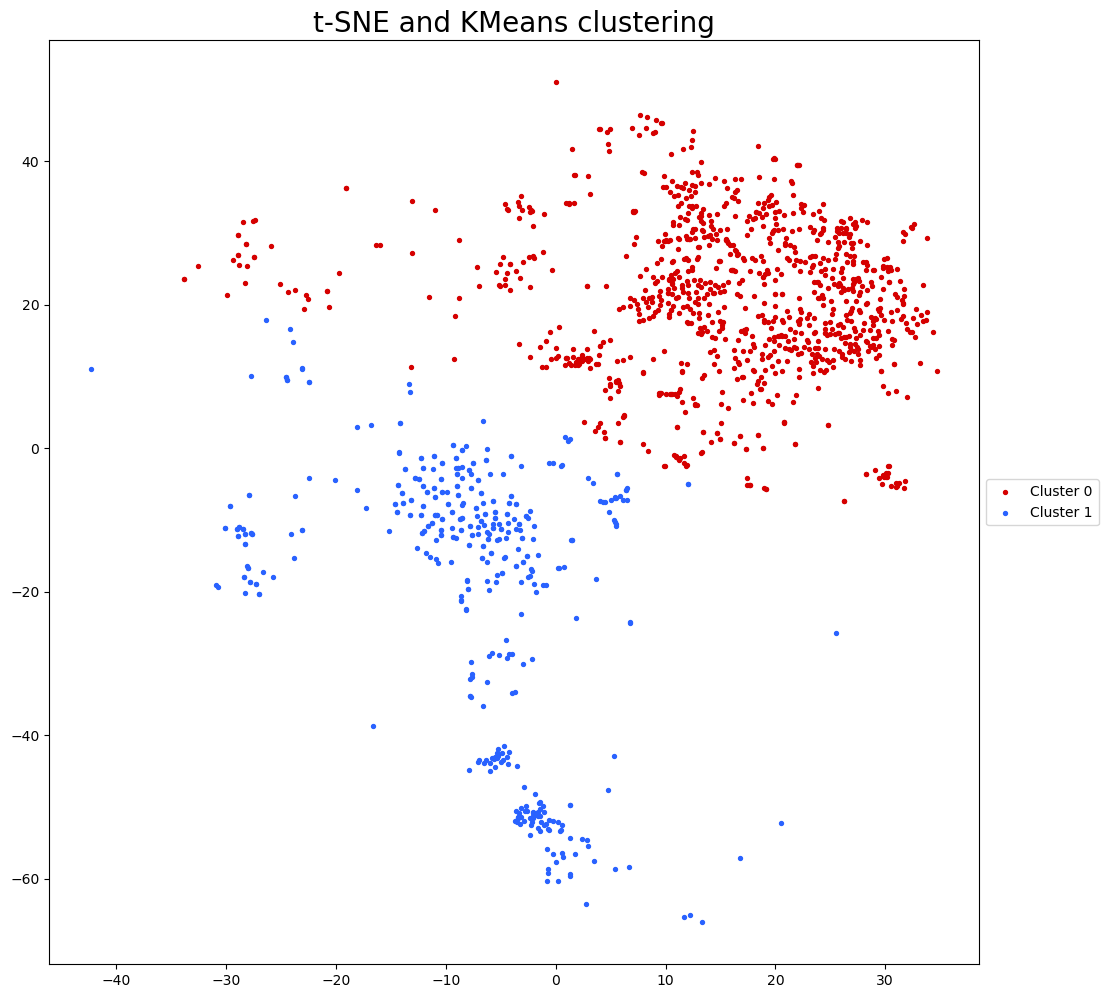

In [34]:
clustering_pipeline(feat_df=all_df, y_param=lymph_y_param, colors=all_colors, s=8, algorithm='KMeans',manual_n_clusters=None, subset_values=['Thoracic', 'Abdominal', 'Pelvic', 'Head and Neck'])                    

100%|██████████| 200/200 [00:15<00:00, 12.55trial/s, best loss: -0.5249626864945227]
Best AgglomerativeClustering parameters: {'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'complete'}
Variation of Information: 0.7698248882739938
Adjusted Rand Index: 0.510912881286012
Wasserstein Distance: 1.0292517006802722
Silhoutte Score: 0.5390124917030334

Contingency Table (Ground Truth vs Cluster):
Cluster          0    1
Ground Truth           
Abdominal      779    8
Head and Neck    4    0
Pelvic          55    2
Thoracic       161  461

Percentage of each Ground Truth in each Cluster:
Cluster                 0          1
Ground Truth                        
Abdominal       98.983482   1.016518
Head and Neck  100.000000   0.000000
Pelvic          96.491228   3.508772
Thoracic        25.884244  74.115756

Percentage of each Cluster in each Ground Truth:
Cluster                0          1
Ground Truth                       
Abdominal      77.977978   1.698514
Head and Neck   0.400400   

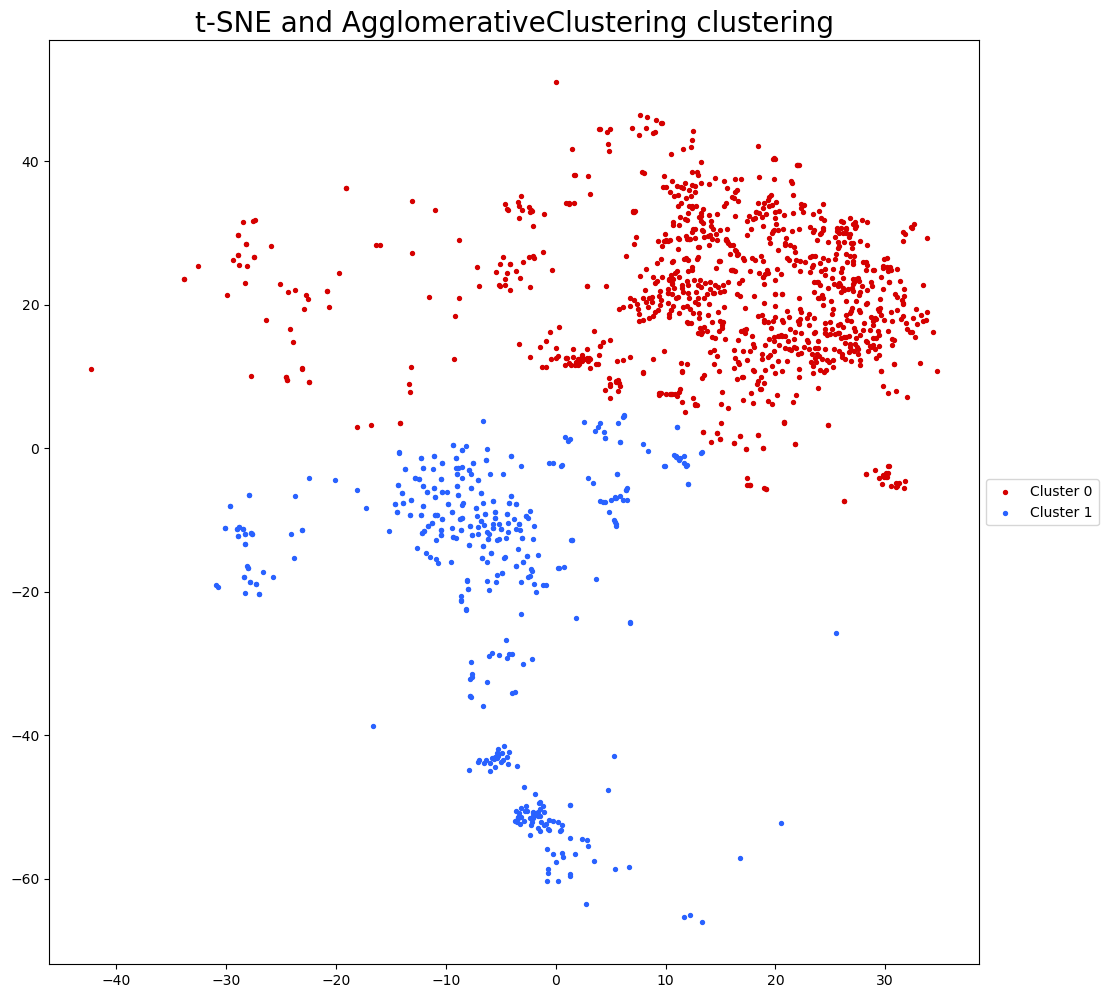

In [35]:
clustering_pipeline(feat_df=all_df, y_param=lymph_y_param, colors=all_colors, s=8, algorithm='AgglomerativeClustering', manual_n_clusters=None, subset_values=['Thoracic', 'Abdominal', 'Pelvic', 'Head and Neck'])                    